# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks :
    + Data augmentation: flipped images, greylevel image editing, etc. You can explore the Keras image augmentation layers https://keras.io/api/layers/preprocessing_layers/image_augmentation/
    + SGD: Changing learning rate and momentum over time.
    + Training: Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.
+ To transform your solution in a Fully Convolutional Network (FCN) to make it independent of the input image size!


> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.
+ How you have implemented the FCN (including one inference example).

The final model can be developed in Tensorflow or in Keras.

In [ ]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

# These files are also available in campus virtual

--2022-11-20 16:14:15--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2022-11-20 16:14:16--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2b39b639d762956ba7a8a0e289.dl.dropboxusercontent.com/cd/0/inline/BxH81R5rFKgy94gUON96xqrVWReFvSLXtUQFoj8AAFFYkSUUSoPyL6M7UhXpWUADGYGu6Far7H5pdn4ndMf2ugqZ_8hy2AqmvraBevMvzlED8CKElSsDzDcwlNy-tKuyxT4zo2ZcCbCqyMmcnwQj1tLyN-egt1uGcvVReq8sv6ry0Q/file# [following]
--2022-11-20 16:14:16--  https://uc2b39b639d762956ba7a8a0e289.dl.dropboxusercontent.com/cd/0/inline/BxH81R5rFKgy94gUON96xqrVWReFvSLXtUQFoj8AAFFYkSUUSoPyL6M7UhXpWUADGYGu6Far7H5pdn4ndMf2ugqZ_8

In [ ]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

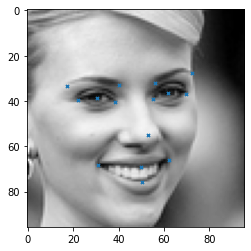

In [ ]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

(1498, 96, 96, 1)


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 30)                1

In [ ]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 10s 104ms/step - loss: 0.3079 - val_loss: 0.1578
Epoch 2/50
11/11 [==============================] - 1s 58ms/step - loss: 0.1414 - val_loss: 0.1207
Epoch 3/50
11/11 [==============================] - 1s 54ms/step - loss: 0.1121 - val_loss: 0.1034
Epoch 4/50
11/11 [==============================] - 1s 54ms/step - loss: 0.0858 - val_loss: 0.0768
Epoch 5/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0706 - val_loss: 0.0641
Epoch 6/50
11/11 [==============================] - 1s 58ms/step - loss: 0.0602 - val_loss: 0.0568
Epoch 7/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0550 - val_loss: 0.0516
Epoch 8/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0503 - val_loss: 0.0476
Epoch 9/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0449 - val_loss: 0.0445
Epoch 10/50
11/11 [==============================] - 1s 58ms/step - loss: 0.0428 - val_loss: 0.0448
Epoch 1

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 9ms/step
Mean pixel error:  2.031366


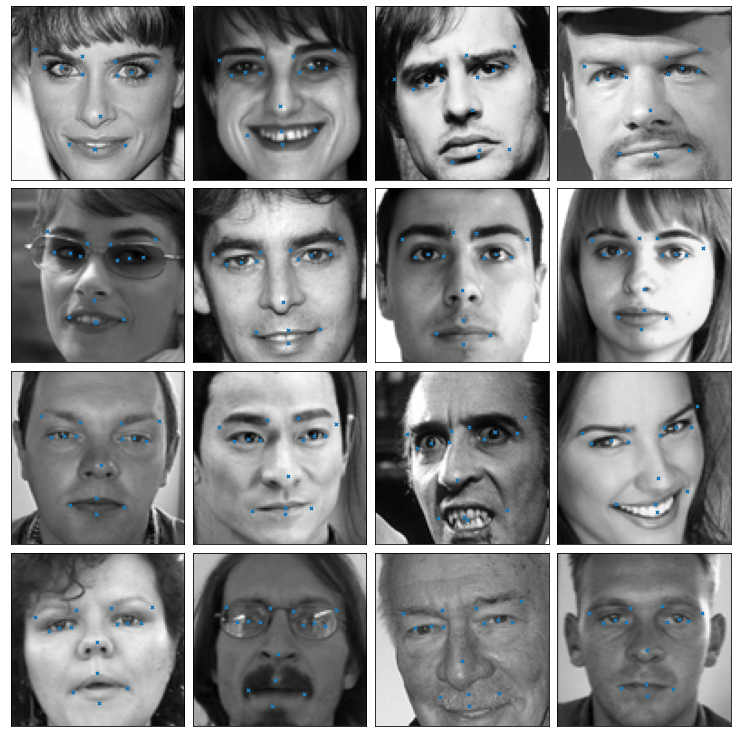

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

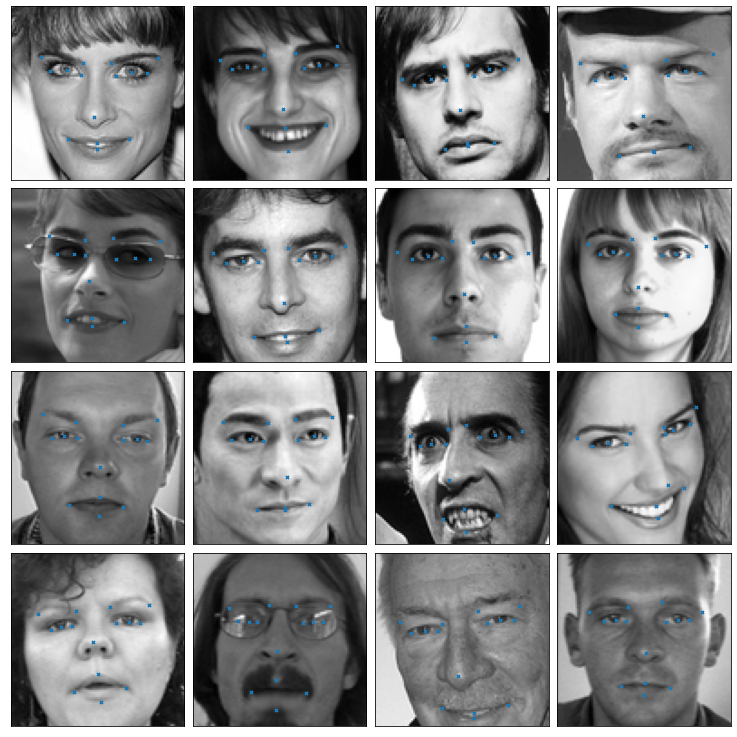

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Assignment 2: improvements

## Initialization

In [ ]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

# These files are also available in campus virtual

--2022-11-24 16:00:35--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2022-11-24 16:00:35--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce8fa7c4a838ad088d5fc89a97c.dl.dropboxusercontent.com/cd/0/inline/BxUYe_1heyUtRn_GN9i9qCu7fEOYdKMmXCENqkq-24s2loDdY-W2AvsFIMWTVPWmXOYLe_EeZM7GHm1VUd41f4rgceEu9iJQQq2CVaXGODmCtfOLVpLWc_mmM13bfTimjSniZS1epug3hUL-8xQVzsKQCpa5KbLlYs_IJmWzVnj9GQ/file# [following]
--2022-11-24 16:00:35--  https://uce8fa7c4a838ad088d5fc89a97c.dl.dropboxusercontent.com/cd/0/inline/BxUYe_1heyUtRn_GN9i9qCu7fEOYdKMmXCENqkq-24s2loDdY-W2AvsFIMWTVPWmXOYLe_EeZM7GHm1VUd41f4rgceE

In [ ]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

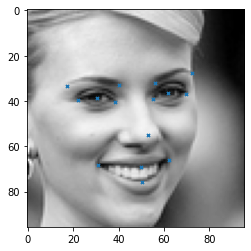

In [ ]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print("X: ", X.shape)
print("y: ", y.shape)
print("x_train: ", x_train.shape)
print("x_valid: ", x_valid.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_valid: ", y_valid.shape)
print("y_test: ", y_test.shape)

X:  (2140, 96, 96)
y:  (2140, 30)
x_train:  (1498, 96, 96, 1)
x_valid:  (321, 96, 96, 1)
x_test:  (321, 96, 96, 1)
y_train:  (1498, 30)
y_valid:  (321, 30)
y_test:  (321, 30)


## Data augmentation: pre-processing

Flip Horizontally/Vertically function

In [ ]:
def flip(X, y, mode):
  new_images = np.copy(X)
  new_labels = np.copy(y)
  S = X.shape[0]
  N = X.shape[1]
  M = X.shape[2]

  if mode=="Horizontally":
    for k in range(0, S):
      for i in range(0, N):
        for j in range(0, M):
          new_images[k,i,j] = X[k,i,M-1-j]

    # Reflect the coordinates
    for k in range(0, y.shape[0]):
      for i in range(0, int(y.shape[1]/2)):
        new_labels[k, i*2] = -y[k, i*2]

    # switch the labels
    toswitch = np.array([[0, 2], [4, 8], [6, 10], [12, 16], [14, 18], [22, 24],      # x coordinates
                         [1, 3], [5, 9], [7, 11], [13, 17], [15, 19], [23, 25]])    # y coordinates
    yt = np.copy(new_labels)
    for k in range(0, y.shape[0]):
      for i in toswitch:
        new_labels[k, i[0]] = yt[k, i[1]]
        new_labels[k, i[1]] = yt[k, i[0]]

  if mode=="Vertically":
    for k in range(0, S):
      for j in range(0, M):
        for i in range(0, N):
          new_images[k,i,j] = X[k,N-1-i,j]
          
    # Reflect the coordinates
    for k in range(0, y.shape[0]):
      for i in range(0, int(y.shape[1]/2)):
        new_labels[k, i*2+1] = -y[k, i*2+1]

    # switch the labels
    toswitch = np.array([[26, 28],      # x coordinates
                         [27, 29]])    # y coordinates
    yt = np.copy(new_labels)
    for k in range(0, y.shape[0]):
      for i in toswitch:
        new_labels[k, i[0]] = yt[k, i[1]]
        new_labels[k, i[1]] = yt[k, i[0]]

  return new_images, new_labels

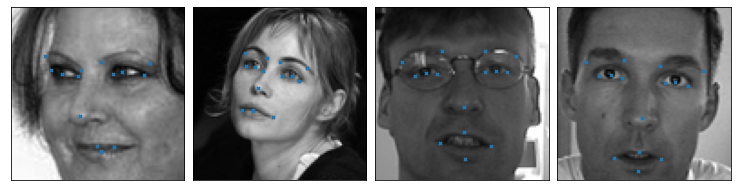

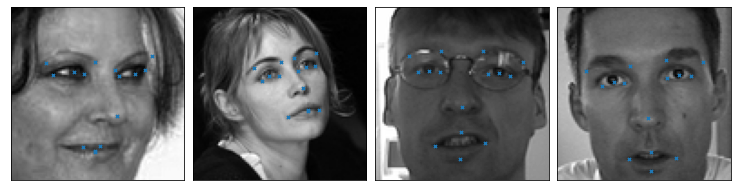

In [ ]:
new_images, new_labels = flip(x_train, y_train, "Horizontally")

fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_train[i,:,:,0],y_train[i])
pyplot.show()

fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    plot_sample(new_images[i,:,:,0],new_labels[i])
pyplot.show()

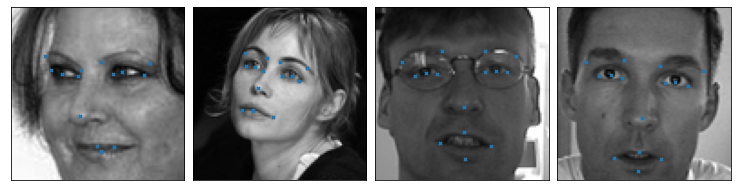

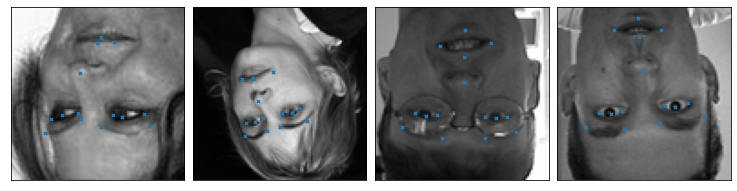

In [ ]:
new_images, new_labels = flip(x_train, y_train, "Vertically")

fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_train[i,:,:,0],y_train[i])
pyplot.show()

fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    plot_sample(new_images[i,:,:,0],new_labels[i])
pyplot.show()

crop spots function

In [ ]:
def crop_spots(X, spots):
  new_images = np.copy(X)
  S = X.shape[0]
  N = X.shape[1]
  M = X.shape[2]

  for k in range(0, S):
    random_pairs = np.random.randint(1, 95, [spots, 2])
    for pair in random_pairs:
      for i in range(-1, 2):
        for j in range(-1, 2):
          new_images[k,pair[0]+i,pair[1]+j] = 0

  return new_images

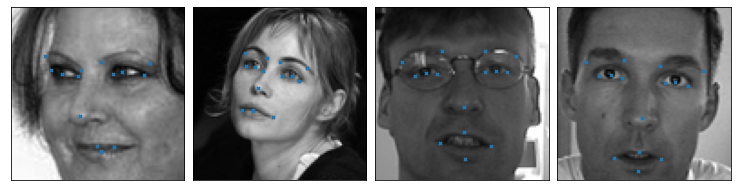

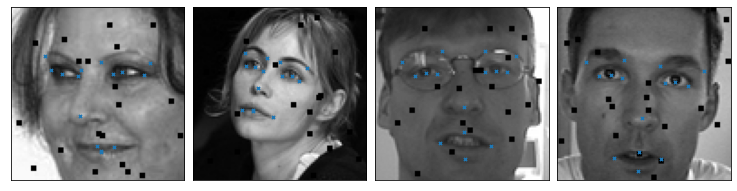

In [ ]:
new_images = crop_spots(x_train, 20)

fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_train[i,:,:,0],y_train[i])
pyplot.show()

fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    plot_sample(new_images[i,:,:,0],y_train[i])
pyplot.show()

Lower resolution function

In [ ]:
def low_res(X, factor):
  new_images = np.copy(X)
  S = X.shape[0]
  N = X.shape[1]
  M = X.shape[2]

  for k in range(0, S):
    for i in range(0, int(N/factor)):
      for j in range(0, int(M)):
        for f in range(factor):
          new_images[k,i*factor+f,j] = X[k,i*factor,j]

  return new_images

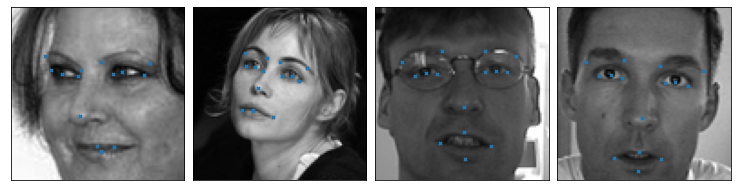

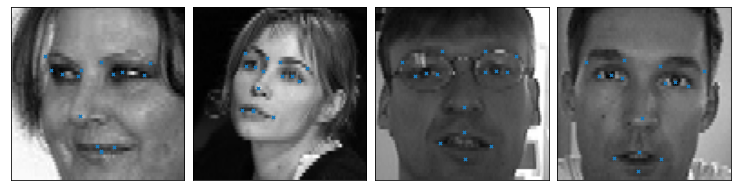

In [ ]:
new_images = low_res(x_train, 2)

fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_train[i,:,:,0],y_train[i])
pyplot.show()

fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    plot_sample(new_images[i,:,:,0],y_train[i])
pyplot.show()

Blur the image function

In [ ]:
from scipy.ndimage.filters import gaussian_filter

def blur(X, sigma):
  new_images = np.copy(X)
  S = X.shape[0]

  for k in range(0, S):
    new_images[k] = gaussian_filter(X[k], sigma)

  return new_images

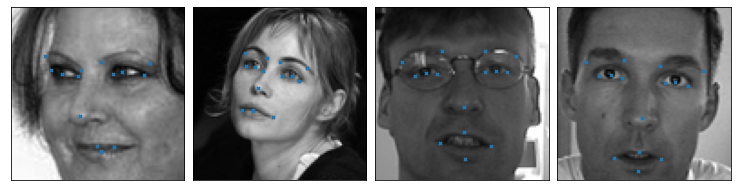

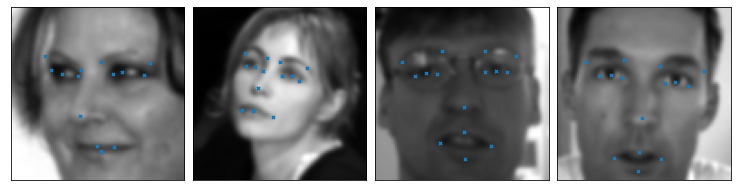

In [ ]:
new_images = blur(x_train, 1.2)

fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_train[i,:,:,0],y_train[i])
pyplot.show()

fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    plot_sample(new_images[i,:,:,0],y_train[i])
pyplot.show()

Define a function to implement all the data augmentation pre processing

In [ ]:
def data_augmentation(X, y):

  # Initialize the new dataset and labels 
  X_aug = np.copy(X)
  y_aug = np.copy(y)

  # Flip horizontally
  X_new, y_new = flip(X, y, "Horizontally")
  # Concatenate the dataset with the new data
  X_aug = tf.concat([X_aug, X_new], 0)
  y_aug = tf.concat([y_aug, y_new], 0)

  # Flip vertically
  #X_new, y_new = flip(X, y, "Vertically")
  # Concatenate the dataset with the new data
  #X_aug = tf.concat([X_aug, X_new], 0)
  #y_aug = tf.concat([y_aug, y_new], 0)

  # Blur
  #X_new = blur(X_aug, 1.2)
  #X_aug = tf.concat([X_aug, X_new], 0)
  #y_aug = tf.concat([y_aug, y_aug], 0)

  # low_res
  #X_new = low_res(X_aug, 2)
  #X_aug = tf.concat([X_aug, X_new], 0)
  #y_aug = tf.concat([y_aug, y_aug], 0)

  # Crop sposts
  #X_new = crop_spots(X_aug, 20)
  #X_aug = tf.concat([X_aug, X_new], 0)
  #y_aug = tf.concat([y_aug, y_aug], 0)

  return X_aug, y_aug

In [ ]:
# Run the data augmentation pre processing on the train images and labels ------
x_train_aug, y_train_aug = data_augmentation(x_train, y_train)
print("Resulting dimensions of the augmented train dataset: ", x_train_aug.shape)

Resulting dimensions of the augmented train dataset:  (2996, 96, 96, 1)


## Data augmentation: layers (during training)

In [ ]:
import numpy as np
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential([
  #layers.Dropout(0.1, noise_shape=None, seed=None, **kwargs)
  #layers.RandomRotation(factor=0.3, fill_mode="wrap"),
  #layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap"),
  #layers.RandomFlip(mode="horizontal", seed=536),
  layers.RandomContrast(factor=0.2),
  #layers.RandomHeight(factor=0.2),
  #layers.RandomWidth(factor=0.2)
])

## Model design

In [ ]:
import numpy as np
from tensorflow import keras
from keras import layers

#python3 -m pip install tensorflow-gpu==2.8.3

# Use a Fully Convolutional Neural Network -------------------------------------
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
      keras.Input(shape=input_shape),
      # Data augmentation during training
      #tf.keras.layers.RandomContrast(factor=0.2),
      #tf.keras.layers.RandomBrightness(factor=0.2),
     
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dense(output_shape, activation="linear")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

## Model training and validation

In [ ]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train_aug, y_train_aug, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 2s 145ms/step
Mean pixel error:  2.703596


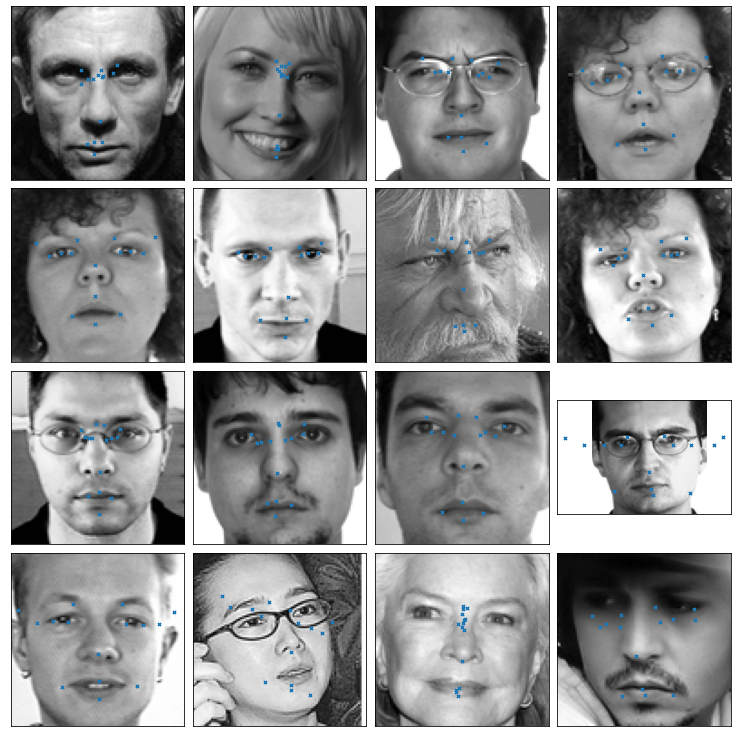

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

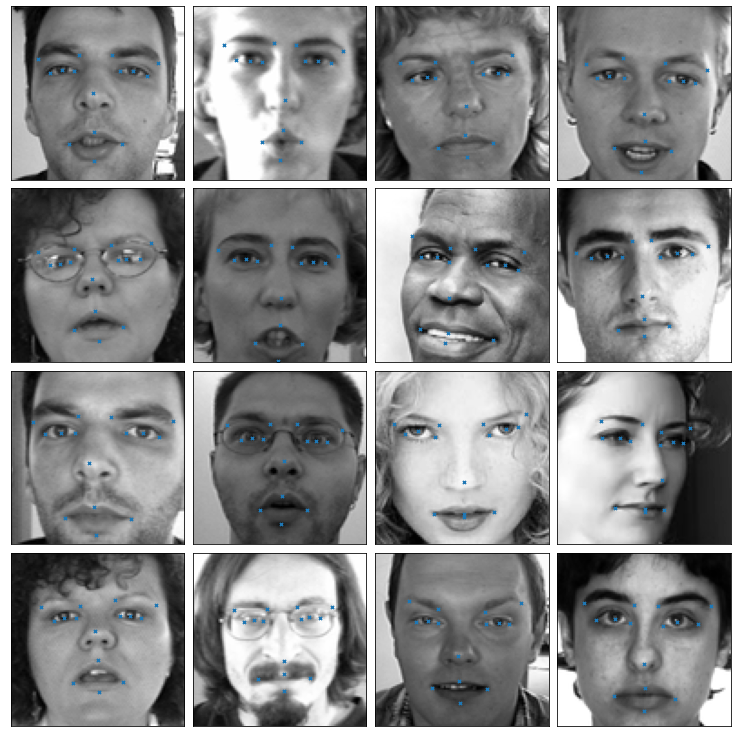

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error is

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**:

## What is the architecture of your FCN?
### Insert one of the test images in a larger image and show the detection result. The size of the face cannor change!



